In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import pickle
import joblib

from tensorflow import keras

from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dropout

tf.__version__

'2.7.0'

In [2]:
#data Preprocessing (Note: we can use another method also but this method saves time)
datagen = ImageDataGenerator(rescale=1./255)
###########################################################################################
train_generator = datagen.flow_from_directory('intel_image/seg_train')
test_generator = datagen.flow_from_directory('intel_image/seg_test', target_size=(224, 224),class_mode='binary')
###########################################################################################
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
###########################################################################################
train_generator = datagen.flow_from_directory('intel_image/seg_train', target_size=(224, 224), subset='training', class_mode='binary')
val_generator = datagen.flow_from_directory('intel_image/seg_train', target_size=(224, 224), subset='validation', class_mode='binary')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


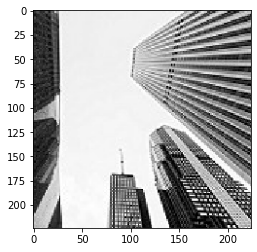

In [3]:
#data exploration
plt.imshow(train_generator[0][0][0])

In [4]:
#data exploration
print(train_generator[0][0][0].shape)
print(test_generator[0][0][0].shape)
print(val_generator[0][0][0].shape)
print(train_generator[0][0][0].dtype)
print(test_generator[0][0][0].dtype)
print(val_generator[0][0][0].dtype)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
float32
float32
float32


In [5]:
#Resizing images (Note: train_generator contain lebels also in it.)
train_generator[0][0][0]=train_generator[0][0][0].reshape(-1,224,224,3)

In [6]:
#model building
model = keras.models.Sequential([

                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',input_shape=(224,224,3)),
                    layers.MaxPooling2D((5, 5)),               

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
                    layers.AveragePooling2D((3, 3)),
    
                    layers.Dropout(0.05),

                    layers.Flatten(),

                    layers.Dense(200,activation="relu"),
                    layers.Dense(150,activation="relu"),
                    layers.Dense(100,activation="relu"),
                    layers.Dense(50,activation="relu"),
    
                    layers.Dense(10,activation="softmax")
])

In [36]:
#compile model
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [37]:
#fit model
model.fit(train_generator,epochs=5)

Epoch 1/5
351/351 [==============================] - 128s 365ms/step - loss: 1.7919 - accuracy: 0.1790
Epoch 2/5
351/351 [==============================] - 124s 352ms/step - loss: 1.7911 - accuracy: 0.1790
Epoch 3/5
351/351 [==============================] - 119s 339ms/step - loss: 1.7909 - accuracy: 0.1790
Epoch 4/5
351/351 [==============================] - 119s 340ms/step - loss: 1.7909 - accuracy: 0.1790
Epoch 5/5
351/351 [==============================] - 122s 348ms/step - loss: 1.7909 - accuracy: 0.1790


In [20]:
#evaluation/testing
model.evaluate(test_generator)

94/94 [==============================] - 17s 182ms/step - loss: 7.7065 - accuracy: 0.1700


[7.706479072570801, 0.17000000178813934]

In [21]:
model.evaluate(val_generator)

88/88 [==============================] - 16s 180ms/step - loss: 8.1471 - accuracy: 0.1619


[8.147064208984375, 0.16191156208515167]

In [22]:
k=model.predict(test_generator)
print("Prediction: ")
print("-------------------------------")
print(np.argmax(k[0]),np.argmax(k[1]),np.argmax(k[2]),np.argmax(k[3]),np.argmax(k[4]))

Prediction: 
-------------------------------
4 4 4 4 4


# Saving and Loading Model

In [35]:
#Saving Model (Method 1: Not Working in this version)
'''
#Saving model
#intel_model = pickle.dumps(model)
#loading model
#model = pickle.loads(intel_model)
'''

'\n#Saving model\n#intel_model = pickle.dumps(model)\n#loading model\n#model = pickle.loads(intel_model)\n'

In [28]:
# Method 2: (Working)
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [29]:
# deletes the existing model
# del model

In [31]:
#Loading Model
# returns a compiled model - identical to the previous one
model1 = load_model('my_model.h5')

In [32]:
k=model1.predict(test_generator)
print("Prediction: ")
print("-------------------------------")
print(np.argmax(k[0]),np.argmax(k[1]),np.argmax(k[2]),np.argmax(k[3]),np.argmax(k[4]))

Prediction: 
-------------------------------
4 4 4 4 4


# Transfer Learning

In [47]:
#transfer learning
import cv2
import PIL.Image as Image
import os

In [48]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))])

In [49]:
predicted = classifier.predict(np.array([cv2.resize(train_generator[0][0][0],(224,224))]))
predicted = np.argmax(predicted, axis=1)
predicted # output : sea [according to label list]

array([973], dtype=int64)

In [50]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [67]:
model_2 = keras.models.Sequential
([
      pretrained_model_without_top_layer,
      keras.layers.Dense(5)
])

In [ ]:
model_2.compile()

In [ ]:
model_2.fit(train_generator, epochs=5)

In [ ]:
model_2.evaluate(test_generator)

In [ ]:
model_2.evaluate(val_generator)